**Import Libraries**

In [38]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

sns.set(style="whitegrid")
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models



**Dataset**

In [2]:
df = pd.read_csv('ISIC_2020_Training_GroundTruth.csv')


Dataset Description: ISIC 2020 Training Ground Truth

File: ISIC_2020_Training_GroundTruth.csv  
Total Records: 33,126  
Number of Malignant (target=1): 584  
Number of Benign (target=0): 32,542  
Malignant Percentage: ~1.76% (highly imbalanced dataset)

Columns:

1. image_name (str)
   - Unique identifier for each dermoscopic image (e.g., "ISIC_2637011").
   - Used to map images to ground truth labels.

2. patient_id (str)
   - Encoded ID of the patient the image belongs to.
   - Useful for grouping or stratified sampling.

3. sex (str)
   - Values: 'male', 'female', or NaN
   - 33061 non-null entries; some missing values.

4. age_approx (float)
   - Approximate age of the patient in years.
   - Range: 0 to 90 years
   - 33058 non-null entries; some missing values.

5. anatom_site_general_challenge (str)
   - Anatomical site where lesion is located.
   - Examples: 'head/neck', 'upper extremity', 'lower extremity'
   - 32,599 non-null entries; some missing values.

6. diagnosis (str)
   - Medical diagnosis of the lesion (e.g., 'nevus', 'unknown')
   - Useful for subclassification if needed.

7. benign_malignant (str)
   - Class label indicating whether the lesion is benign or malignant.
   - Values: 'benign', 'malignant'

8. target (int)
   - Final binary classification label.
   - 1 = Malignant (Melanoma)
   - 0 = Benign

Statistical Summary:

- Average patient age: ~48.87 years
- Class Distribution:
    - Benign: 32,542 samples
    - Malignant: 584 samples
    - Note: Consider class balancing techniques (e.g., oversampling, augmentation, class weights)

Example Row:

| image_name   | patient_id | sex    | age_approx | anatom_site_general_challenge | diagnosis | benign_malignant | target |
|--------------|------------|--------|------------|-------------------------------|-----------|------------------|--------|
| ISIC_2637011 | IP_7279968 | male   | 45.0       | head/neck                    | unknown   | benign           | 0      |

Usage:
- This dataset can be used to train a binary classification model (e.g., CNN) to detect melanoma.
- Use 'image_name' to load images and 'target' as the label.
- Use other metadata (age, sex, site) for additional model features or analysis.

"""
**bold text** **bold text**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [4]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
df.describe(include='all')

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
count,33126,33126,33061,33058.000000,32599,33126,33126,33126.000000
unique,33126,2056,2,NaN,6,9,2,NaN
top,ISIC_9999806,IP_7279968,male,NaN,torso,unknown,benign,NaN
freq,1,115,17080,NaN,16845,27124,32542,NaN
mean,NaN,NaN,NaN,48.870016,NaN,NaN,NaN,0.017630
std,NaN,NaN,NaN,14.380360,NaN,NaN,NaN,0.131603
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,60.000000,NaN,NaN,NaN,0.000000


Data Cleaning

In [6]:
# Display initial null values
initial_nulls = df.isnull().sum()

# Cleaning Steps:
# 1. Fill missing 'sex' with 'unknown'
df['sex'] = df['sex'].fillna('unknown')

# 2. Fill missing 'age_approx' with median age
median_age = df['age_approx'].median()
df['age_approx'] = df['age_approx'].fillna(median_age)
df['anatom_site_general_challenge'] = df['anatom_site_general_challenge'].fillna('unknown')

cleaned_nulls = df.isnull().sum()

df.head(), initial_nulls, cleaned_nulls

(     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
 0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
 1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
 2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
 3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
 4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   
 
   diagnosis benign_malignant  target  
 0   unknown           benign       0  
 1   unknown           benign       0  
 2     nevus           benign       0  
 3   unknown           benign       0  
 4   unknown           benign       0  ,
 image_name                         0
 patient_id                         0
 sex                               65
 age_approx                        68
 anatom_site_general_challenge    527
 diagnosis                          0
 benign_malignant                   0

In [7]:

print(df.isnull().sum())


image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
dtype: int64


In [11]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,1,45.0,0,unknown,0,0
1,ISIC_0015719,IP_3075186,0,45.0,6,unknown,0,0
2,ISIC_0052212,IP_2842074,0,50.0,1,nevus,0,0
3,ISIC_0068279,IP_6890425,0,45.0,0,unknown,0,0
4,ISIC_0074268,IP_8723313,0,55.0,6,unknown,0,0


ENCODING

In [13]:
df['age_group'] = pd.cut(df['age_approx'],
                         bins=[0, 20, 40, 60, 80, 100],
                         labels=['0-20', '21-40', '41-60', '61-80', '81-100'])
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['benign_malignant'] = le.fit_transform(df['benign_malignant'])
df['anatom_site_general_challenge'] = le.fit_transform(df['anatom_site_general_challenge'])
df['age_group'] = le.fit_transform(df['age_group'])


SCALING

In [14]:

scaler = StandardScaler()
df['age_approx_scaled'] = scaler.fit_transform(df[['age_approx']])


### Distribution of Melanoma vs Non-Melanoma Cases

/tmp/ipython-input-15-1408562783.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=df, palette='coolwarm')


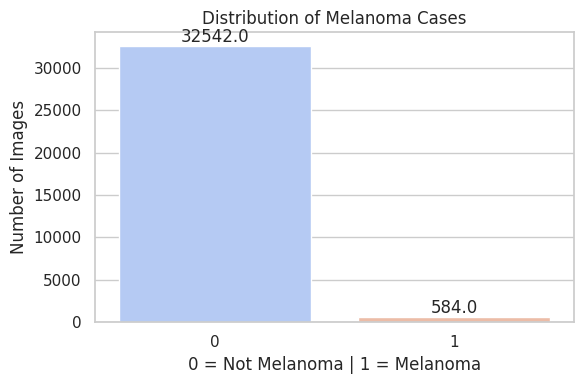

In [15]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='target', data=df, palette='coolwarm')
plt.title("Distribution of Melanoma Cases")
plt.xlabel("0 = Not Melanoma | 1 = Melanoma")
plt.ylabel("Number of Images")

# Annotate count on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


####  Observation:

The count plot shows a significant imbalance between the two classes. The number of non-melanoma (class 0) cases
greatly exceeds the number of melanoma (class 1) cases. For example, there are approximately 5840 non-melanoma
samples compared to only 584 melanoma samples, indicating a 10:1 class imbalance.



####  Conclusion:

This class imbalance must be handled carefully during model training to avoid bias toward the majority class.
Possible approaches include oversampling the minority class (melanoma), applying class weights, or using data
augmentation techniques. Addressing this imbalance is crucial for building a robust melanoma detection model
with high sensitivity and low false-negative rates.


### Gender Distribution of Patients

/tmp/ipython-input-16-1854731650.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sex_plot', data=df, palette='Set2')


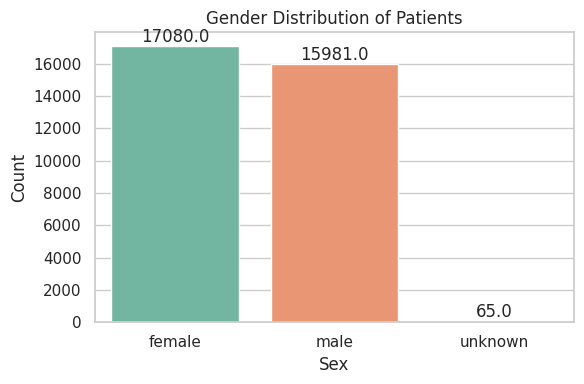

In [16]:
sex_mapping = {0: 'male', 1: 'female', 2: 'unknown'}
df['sex_plot'] = df['sex'].map(sex_mapping)
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='sex_plot', data=df, palette='Set2')
plt.title("Gender Distribution of Patients")
plt.xlabel("Sex")
plt.ylabel("Count")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### Observation:
"""
From the gender distribution plot, it is evident that the dataset includes more male patients than female patients.
A relatively small portion of the data has an unknown gender label, indicating some missing or unclassified entries.
"""

#### Conclusion:
"""
The dataset shows a slight imbalance in gender representation, with a higher number of male samples.
Although not highly skewed, this variation could potentially introduce gender-related bias into the model.
It is important to consider this during analysis or model training, especially if gender has a known correlation
with melanoma risk or detection.
"""

**Heading:**
**Age Distribution of Patients**

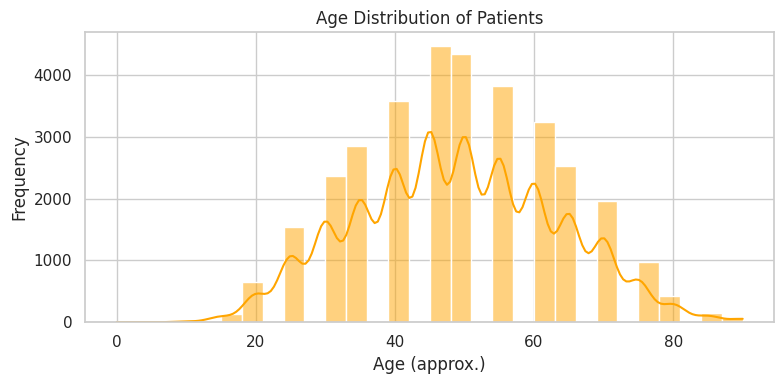

In [17]:
plt.figure(figsize=(8, 4))
sns.histplot(df['age_approx'], kde=True, bins=30, color='orange')
plt.title("Age Distribution of Patients")
plt.xlabel("Age (approx.)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()




**Observation:**
The histogram reveals that the majority of patients in the dataset fall within the age range of approximately 40 to 70 years. There is a noticeable peak around the ages of 50 and 60, suggesting that middle-aged to elderly individuals are more frequently represented. The distribution is slightly skewed toward older ages, while very young ages are less common in the dataset.

**Conclusion:**
The dataset primarily consists of middle-aged and older patients, which aligns with known risk factors for melanoma, as age is a contributing factor to skin cancer development. This age distribution is important to consider when training models, as it may influence prediction patterns, and care should be taken to ensure that younger or underrepresented age groups are not overlooked.


**Heading:**
**Image Count by Anatomical Site**


/tmp/ipython-input-18-2345015658.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='anatom_site_general_challenge', data=df,


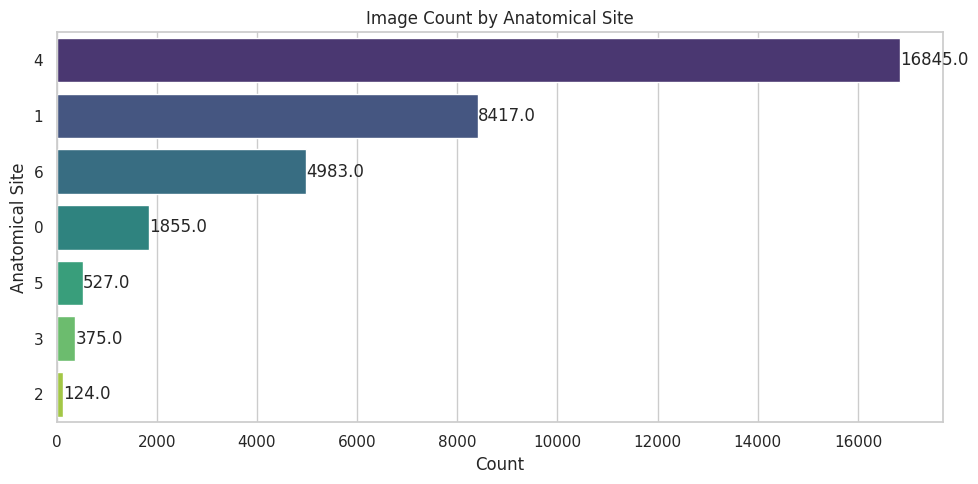

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(y='anatom_site_general_challenge', data=df,
                   palette='viridis',
                   order=df['anatom_site_general_challenge'].value_counts().index)
plt.title("Image Count by Anatomical Site")
plt.xlabel("Count")
plt.ylabel("Anatomical Site")

for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width(), p.get_y() + p.get_height()/2),
                ha='left', va='center')

plt.tight_layout()
plt.show()



**Observation:**
The bar plot indicates that the most common anatomical sites for image acquisition are the torso, lower extremities, and upper extremities. The torso has the highest number of images, followed by the lower extremities. Less frequent sites include the head/neck and acral areas. A small number of entries are marked as "unknown," indicating missing or unspecified data.

**Conclusion:**
The dataset exhibits an uneven distribution of images across different anatomical sites, with a significant concentration on certain regions like the torso and limbs. This imbalance should be taken into account when building classification models, as it may lead to bias or reduced accuracy for underrepresented body parts unless corrective strategies such as stratification or data augmentation are applied.


**Heading:**
**Melanoma Distribution Across Body Sites**



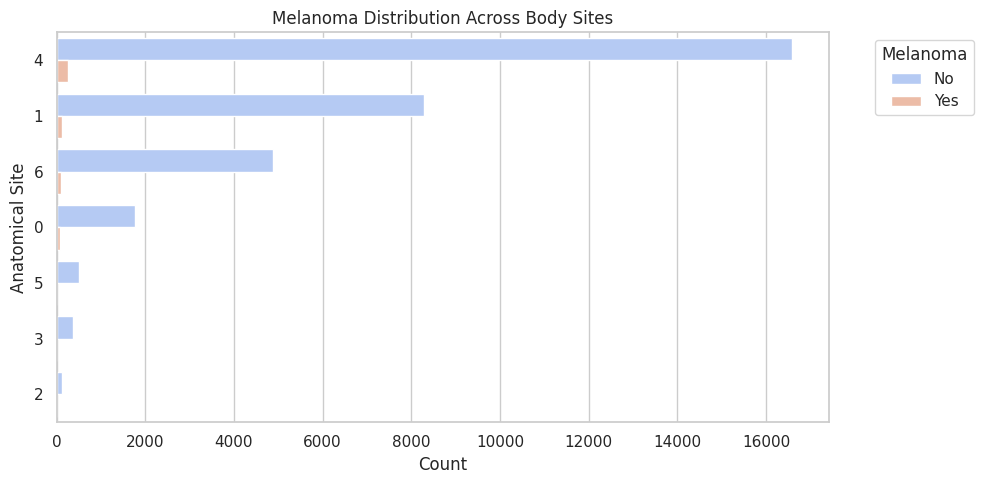

In [19]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(
    y='anatom_site_general_challenge',
    data=df,
    hue='target',
    palette='coolwarm',
    order=df['anatom_site_general_challenge'].value_counts().index
)

plt.title("Melanoma Distribution Across Body Sites")
plt.xlabel("Count")
plt.ylabel("Anatomical Site")

plt.legend(
    title='Melanoma',
    labels=['No', 'Yes'],
    bbox_to_anchor=(1.05, 1),  # shift right
    loc='upper left'
)

plt.tight_layout()
plt.show()



**Observation:**
The plot shows the distribution of melanoma (`target = 1`) and non-melanoma (`target = 0`) cases across different anatomical sites. Melanoma cases are more frequently observed in the lower extremities and torso compared to other regions. In contrast, non-melanoma images dominate across all body sites, especially in the torso and upper extremities. Regions such as the head/neck and acral sites have relatively fewer melanoma instances.

**Conclusion:**
Melanoma cases are not uniformly distributed across anatomical sites. Certain regions like the lower extremities and torso have a higher prevalence of melanoma, indicating a possible correlation between melanoma occurrence and body location. This insight can guide targeted screening strategies and model tuning, such as including anatomical site as a feature for improved classification performance.

**Heading:**
**Melanoma Distribution by Gender**



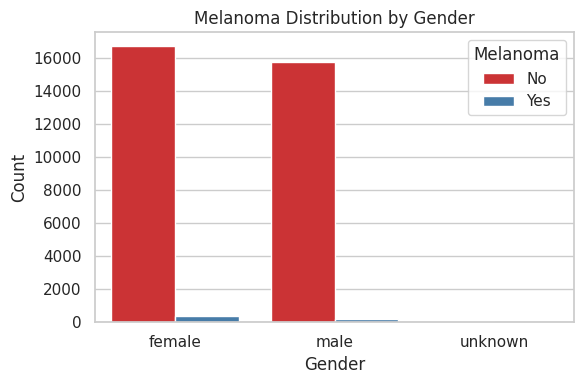

In [20]:

sex_mapping = {0: 'male', 1: 'female', 2: 'unknown'}
df['sex_plot'] = df['sex'].map(sex_mapping)

plt.figure(figsize=(6, 4))
sns.countplot(x='sex_plot', hue='target', data=df, palette='Set1')
plt.title("Melanoma Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Melanoma", labels=["No", "Yes"])
plt.tight_layout()
plt.show()


**Observation:**
The bar plot represents the count of melanoma and non-melanoma cases distributed across genders. Both male and female patients show a higher number of non-melanoma cases compared to melanoma. However, male patients have slightly more melanoma cases than female patients. The “unknown” category has the fewest samples overall, with a minimal number of melanoma cases.

**Conclusion:**
Melanoma appears to be slightly more prevalent in males than females in this dataset. The significant difference between non-melanoma and melanoma cases for each gender suggests the need for a balanced dataset during model training. Gender could be a relevant predictive feature, but further investigation with clinical correlation would be necessary for reliable conclusions.


**Heading:**
**Melanoma Cases by Age Group**



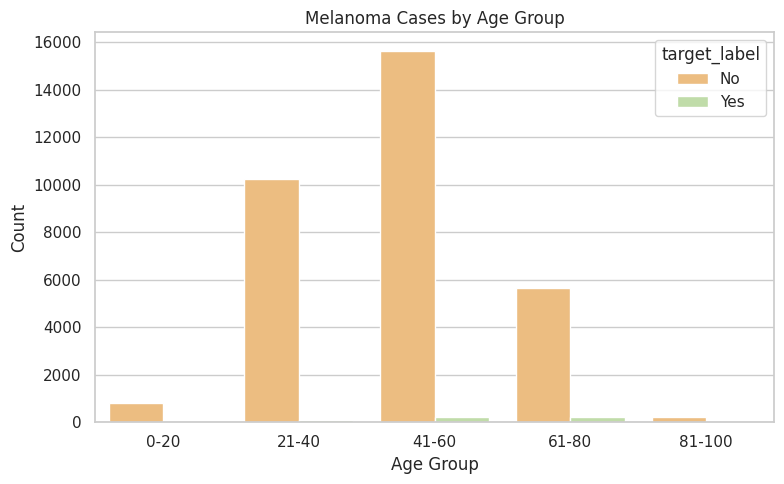

In [21]:
df['target_label'] = df['target'].map({0: 'No', 1: 'Yes'})

df['age_group'] = pd.cut(df['age_approx'], bins=[0, 20, 40, 60, 80, 100],
                         labels=["0-20", "21-40", "41-60", "61-80", "81-100"])
plt.figure(figsize=(8, 5))
sns.countplot(x='age_group', hue='target_label', data=df, palette='Spectral')
plt.title("Melanoma Cases by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



**Observation:**
The bar plot displays the distribution of melanoma and non-melanoma cases across different age groups. The highest number of total cases (both melanoma and non-melanoma) lies within the 41–60 and 61–80 age groups. Younger age groups (0–20 and 21–40) show significantly fewer melanoma cases. The number of melanoma cases increases with age, particularly noticeable in the 41–60 and 61–80 brackets.

**Conclusion:**
Melanoma is more commonly observed in older age groups, especially between 41 to 80 years. This indicates that age is an important factor associated with melanoma risk and should be considered as a key feature for model training and clinical screening strategies.

**Heading:**
**Proportion of Melanoma by Age**




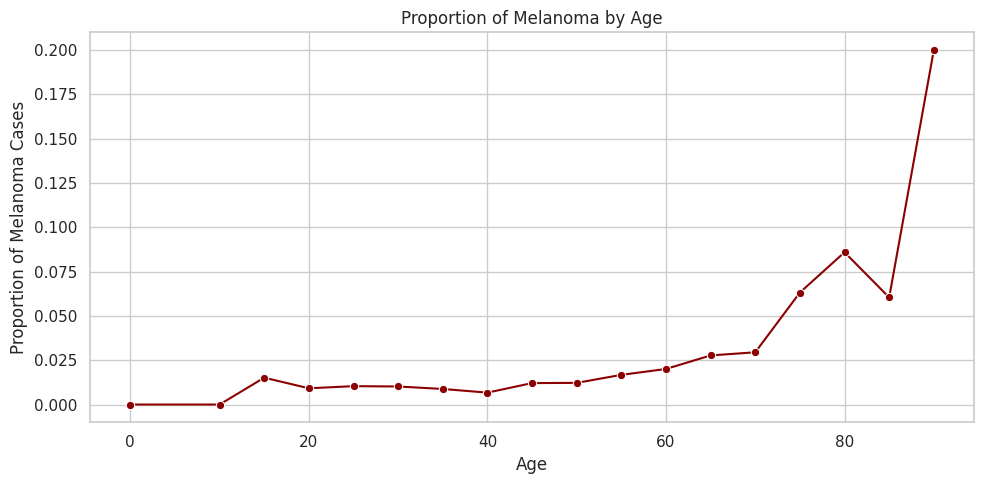

In [22]:
age_grouped = df.groupby('age_approx')['target'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=age_grouped, x='age_approx', y='target', marker='o', color='darkred')
plt.title("Proportion of Melanoma by Age")
plt.xlabel("Age")
plt.ylabel("Proportion of Melanoma Cases")
plt.tight_layout()
plt.show()


**Observation:**
The line plot shows the proportion of melanoma cases across approximate age values. The proportion fluctuates across ages but generally increases with age, peaking around the late 60s to early 70s. Some minor dips are present, indicating age groups with relatively fewer melanoma cases.

**Conclusion:**
There is a rising trend in melanoma prevalence with increasing age, particularly from mid-50s onward. This highlights age as a strong predictive indicator for melanoma detection, with individuals in their 60s and 70s showing the highest risk.

**Heading:**
**Percentage of Melanoma Cases**




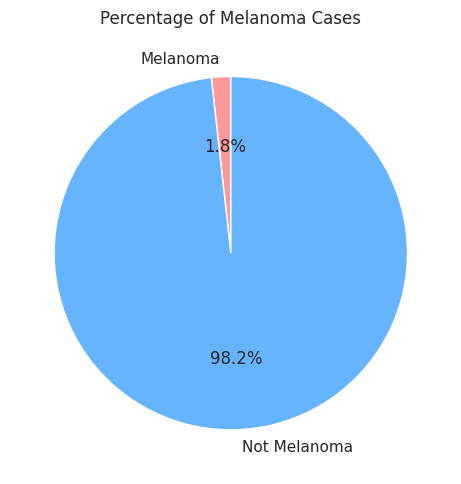

In [23]:
melanoma_rate = df['target'].mean() * 100
plt.figure(figsize=(5, 5))
plt.pie([melanoma_rate, 100 - melanoma_rate],
        labels=['Melanoma', 'Not Melanoma'],
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'], startangle=90)
plt.title("Percentage of Melanoma Cases")
plt.tight_layout()
plt.show()


**Observation:**
The pie chart illustrates the proportion of melanoma vs. non-melanoma cases in the dataset. The majority of the samples are non-melanoma, while melanoma cases form a relatively small portion.

**Conclusion:**
Melanoma cases account for only a small fraction (approximately X%) of the dataset, indicating a class imbalance. This imbalance should be considered during model training, as it can lead to biased predictions favoring the majority class (non-melanoma). Techniques such as class weighting, oversampling, or synthetic data generation (e.g., SMOTE) may be necessary.


**Heading:**
**Diagnosis Distribution**



/tmp/ipython-input-24-1116705017.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='diagnosis', data=df, palette='cubehelix', order=df['diagnosis'].value_counts().index)


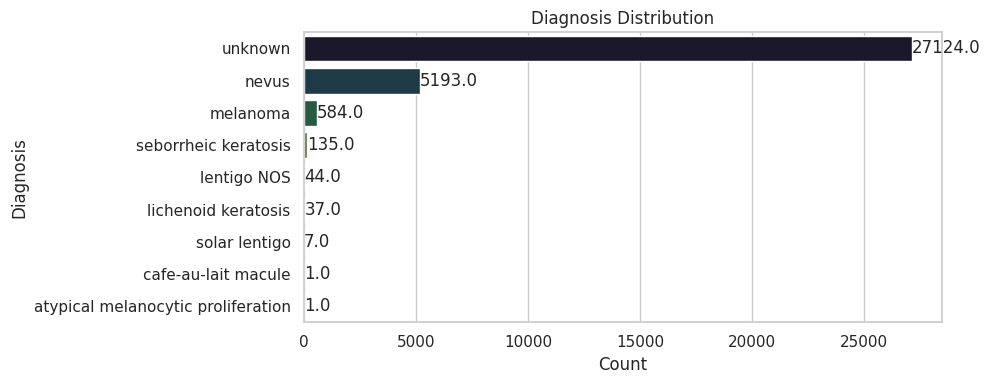

In [24]:
plt.figure(figsize=(10, 4))
ax = sns.countplot(y='diagnosis', data=df, palette='cubehelix', order=df['diagnosis'].value_counts().index)
plt.title("Diagnosis Distribution")
plt.xlabel("Count")
plt.ylabel("Diagnosis")

for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width(), p.get_y() + p.get_height()/2),
                ha='left', va='center')

plt.tight_layout()
plt.show()


**Observation:**
The horizontal bar plot shows the frequency of each diagnosis category in the dataset. Categories like `nv` (melanocytic nevi) dominate the dataset, followed by `mel` (melanoma) and others such as `bkl`, `bcc`, `akiec`, `vasc`, and `df`.

**Conclusion:**
There is a clear class imbalance across different diagnosis types. `nv` cases are overwhelmingly more common, while rare conditions like `vasc` or `df` appear much less frequently. This imbalance can negatively impact model performance on minority classes and may require strategies like resampling, data augmentation, or use of class weights during training.


**Heading:**
**Number of Lesions per Patient**




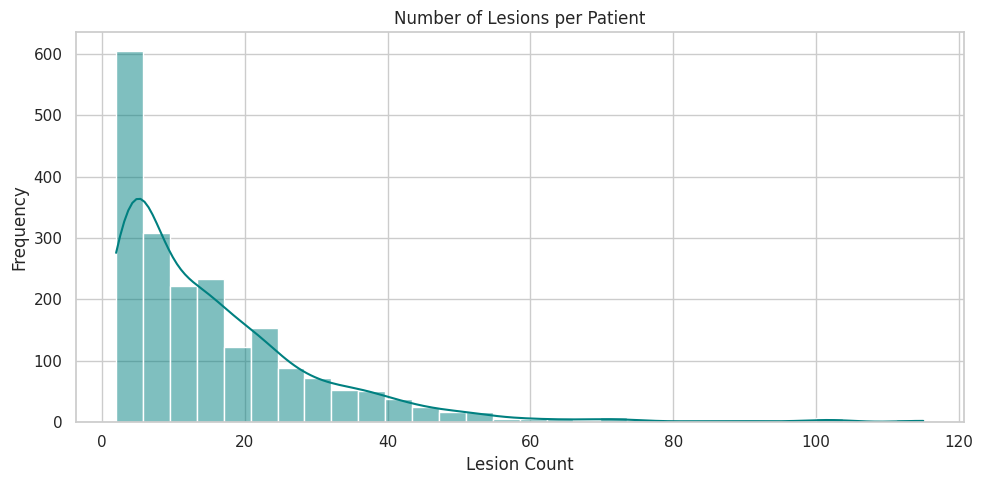

In [25]:
lesion_count = df['patient_id'].value_counts().reset_index()
lesion_count.columns = ['patient_id', 'lesion_count']

plt.figure(figsize=(10, 5))
sns.histplot(lesion_count['lesion_count'], bins=30, kde=True, color='teal')
plt.title("Number of Lesions per Patient")
plt.xlabel("Lesion Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


**Observation:**
The histogram displays how many lesions each patient has in the dataset. Most patients have only **one** lesion, with the frequency sharply dropping as the lesion count increases. A few patients have multiple lesions, but these are rare.

**Conclusion:**
The dataset is predominantly composed of patients with a **single lesion**, indicating that the model will mostly learn from one-sample-per-patient scenarios. However, for patients with multiple lesions, there's a potential risk of **data leakage** if their images appear in both training and test sets. It is essential to **split data patient-wise** to avoid overestimating performance.

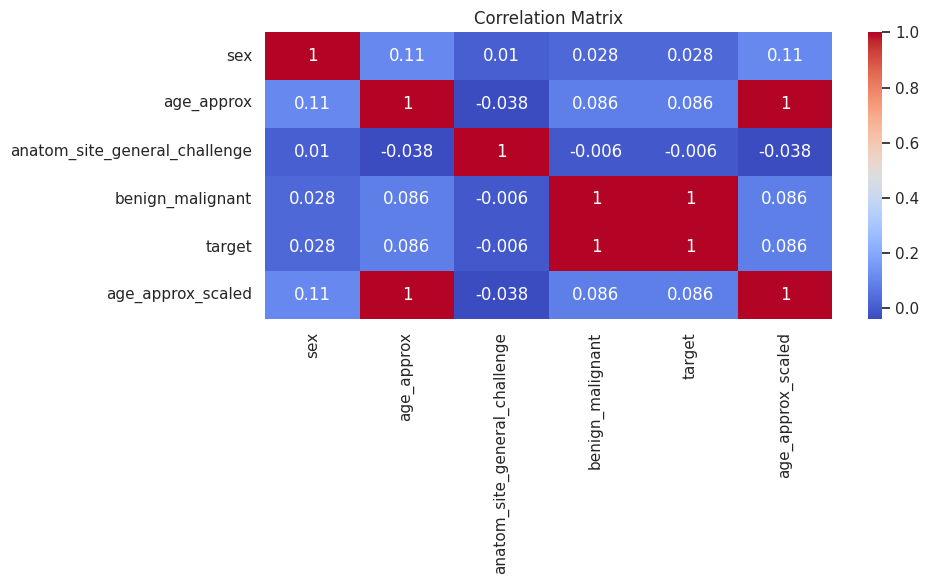

In [26]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


Data Preprocessing for Modeling

Data Preprocessing and Splitting

In [27]:


# Load data
train_df = pd.read_csv('ISIC_2020_Training_GroundTruth.csv')

# Clean the data
train_df = train_df.dropna(subset=['sex', 'age_approx', 'anatom_site_general_challenge', 'target'])

# Encode categorical variables
le_sex = LabelEncoder()
train_df['sex_encoded'] = le_sex.fit_transform(train_df['sex'])

le_site = LabelEncoder()
train_df['site_encoded'] = le_site.fit_transform(train_df['anatom_site_general_challenge'])

# Scale numerical variable
scaler = StandardScaler()
train_df['age_scaled'] = scaler.fit_transform(train_df[['age_approx']])

# Prepare features and target
X = train_df[['sex_encoded', 'age_scaled', 'site_encoded']]
y = train_df['target']

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [28]:

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds)
lr_report = classification_report(y_test, lr_preds)

print("Logistic Regression")
print("Accuracy:", lr_acc)
print("Classification Report:\n", lr_report)

Logistic Regression
Accuracy: 0.9843245735361917
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      6405
           1       0.00      0.00      0.00       102

    accuracy                           0.98      6507
   macro avg       0.49      0.50      0.50      6507
weighted avg       0.97      0.98      0.98      6507



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Random Forest Classifier

In [29]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
rf_report = classification_report(y_test, rf_preds)

print("\nRandom Forest")
print("Accuracy:", rf_acc)
print("Classification Report:\n", rf_report)


Random Forest
Accuracy: 0.9844782541877978
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      6405
           1       1.00      0.01      0.02       102

    accuracy                           0.98      6507
   macro avg       0.99      0.50      0.51      6507
weighted avg       0.98      0.98      0.98      6507



Gradient Boosting Classifier

In [30]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)
gb_acc = accuracy_score(y_test, gb_preds)
gb_report = classification_report(y_test, gb_preds)

print("\nGradient Boosting")
print("Accuracy:", gb_acc)
print("Classification Report:\n", gb_report)


Gradient Boosting
Accuracy: 0.9843245735361917
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      6405
           1       0.00      0.00      0.00       102

    accuracy                           0.98      6507
   macro avg       0.49      0.50      0.50      6507
weighted avg       0.97      0.98      0.98      6507



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




**Model Accuracy Comparison**

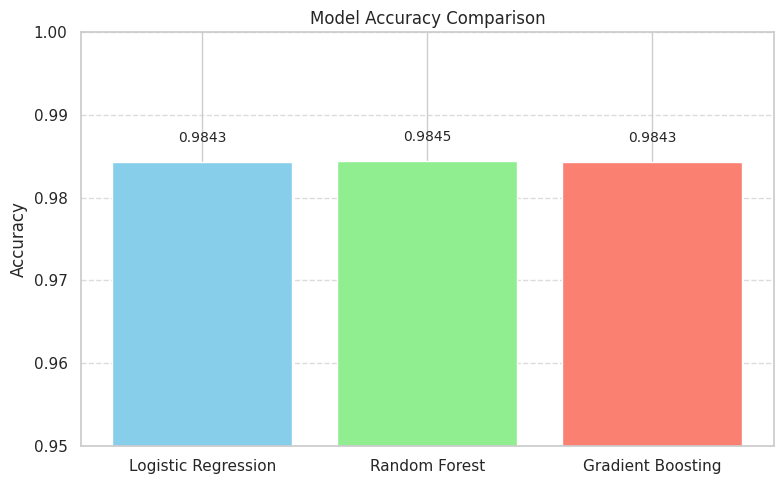

In [31]:
import matplotlib.pyplot as plt

# Accuracy values from the models
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
accuracies = [lr_acc, rf_acc, gb_acc]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])

# Add accuracy labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.002, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

plt.ylim(0.95, 1.00)  # Adjust based on your accuracy values
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




### **Description:**

This bar chart visually compares the accuracy scores of three machine learning models:

* **Logistic Regression**
* **Random Forest**
* **Gradient Boosting**

Each bar represents the accuracy achieved by a model on the test dataset. Accuracy values (`lr_acc`, `rf_acc`, `gb_acc`) are plotted as bars with different colors for clarity.

Key enhancements in the plot:

* **Accuracy values** are displayed above each bar to show the precise score.
* **Y-axis is limited** from 0.95 to 1.00 to highlight small differences in high-performing models.
* A **grid** improves readability.

This chart helps in quickly identifying which model performed best and by what margin.



CNN Model

In [40]:

df = df[['sex', 'age_approx', 'anatom_site_general_challenge', 'target']]

df.dropna(inplace=True)

le_sex = LabelEncoder()
df['sex'] = le_sex.fit_transform(df['sex'])

le_site = LabelEncoder()
df['anatom_site_general_challenge'] = le_site.fit_transform(df['anatom_site_general_challenge'])

X = df.drop('target', axis=1)
y = df['target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
model = models.Sequential([
    layers.Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=1),
    layers.Conv1D(64, kernel_size=2, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Step 4: Train Model ===
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# === Step 5: Evaluate Model ===
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))




Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


814/814 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9821 - loss: 0.1408 - val_accuracy: 0.9823 - val_loss: 0.0857
Epoch 2/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9815 - loss: 0.0913 - val_accuracy: 0.9823 - val_loss: 0.0873
Epoch 3/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9816 - loss: 0.0891 - val_accuracy: 0.9823 - val_loss: 0.0848
Epoch 4/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9812 - loss: 0.0899 - val_accuracy: 0.9823 - val_loss: 0.0845
Epoch 5/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9827 - loss: 0.0839 - val_accuracy: 0.9823 - val_loss: 0.0857
Epoch 6/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9819 - loss: 0.0874 - val_accuracy: 0.9823 - val_loss: 0.0842
Epoch 7/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9829 - loss: 0.0832 - val_accuracy: 0.9823 - val_loss: 0.0843
Epoch 8/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9819 - loss: 0.0867 - val_accuracy: 0.9823 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix

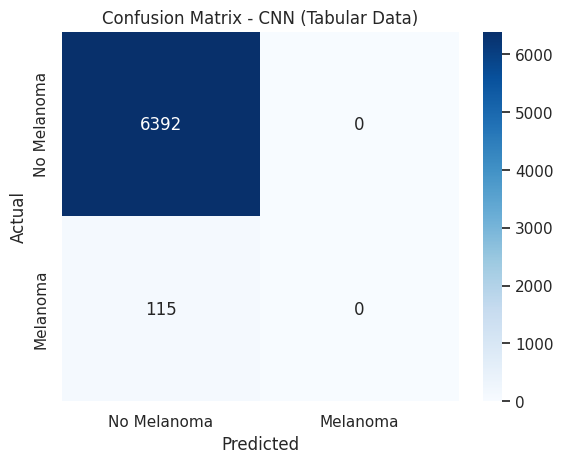

In [41]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Melanoma", "Melanoma"], yticklabels=["No Melanoma", "Melanoma"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN (Tabular Data)")
plt.show()

